## Imports y dependencias

In [ ]:
import math
from collections import Counter
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import time
from datetime import timedelta

from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

### Funciones desarrolladas

In [ ]:
def evaluar_modelo(y_true, y_pred_proba, top_percentiles=[1, 5, 10]):
    """
    Calcula ROC AUC y LIFT en los percentiles indicados (por defecto 1%, 5%, 10%).
    
    Args:
        y_true: array-like, etiquetas reales (0 o 1) -el target-
        y_pred_proba: array-like, probabilidades predichas para la clase positiva
        top_percentiles: lista de percentiles a evaluar para el Lift

    Returns:
        None (imprime las métricas)
    """
    # Crear DataFrame ordenado por score
    df = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_pred_proba
    }).sort_values(by="y_score", ascending=False).reset_index(drop=True)

    # ROC AUC
    auc = roc_auc_score(df["y_true"], df["y_score"])
    print(f"\tROC AUC: {auc:.4f}")

    # Tasa base (porcentaje de positivos en todo el dataset)
    tasa_base = df["y_true"].mean()
    
    lifts = {}
    # Calcular Lift en cada top X%
    for p in top_percentiles: #top_percentiles=[1, 5, 10]
        corte = int(len(df) * p / 100)
        top_df = df.iloc[:corte]
        tasa_top = top_df["y_true"].mean()
        lift = tasa_top / tasa_base if tasa_base > 0 else 0
        lifts[p]=lift
        print(f"\tLift @ top {p}%: {lift:.2f}x")
    return auc, lifts

#Funciones para búsqueda de hiperparámetros
def optimizar_xgboost_random_search(X_train, y_train,scale_pos_weight=1, n_iter=20, cv=3, scoring='roc_auc', random_state=42):
    """
    Optimiza hiperparámetros de XGBoost con Random Search usando solo validación cruzada (sin early stopping).

    Devuelve:
        random_search (RandomizedSearchCV): objeto entrenado con el mejor modelo
    """

    # Distribución de hiperparámetros a buscar

    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.29),  # igual que bayesiana (0.01, 0.3)
        'subsample': uniform(0.5, 0.5),        # igual que bayesiana (0.5, 1.0)
        'colsample_bytree': uniform(0.5, 0.5), # igual que bayesiana (0.5, 1.0)
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 5),
        'reg_lambda': uniform(0, 5)
    }


    # Modelo base
    modelo = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        random_state=random_state
    )

    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=random_state,
        refit=True
    )

    # Entrenamiento (solo con CV)
    random_search.fit(X_train, y_train)

    return random_search



## Carga de conjuntos ```train```, ```val``` y ```test```

In [ ]:
# carga de TRAIN
df_train = pl.read_csv("df_train.csv")

In [4]:
# carga de VAL
df_val = pl.read_csv("df_val.csv")

X_val = df_val.drop("target").to_pandas()
X_val = X_val.apply(pd.to_numeric, errors='coerce')
X_val = pl.from_pandas(X_val)

y_val = df_val["target"]

print("Shape X_val:",X_val.shape)
print("Shape y_val:",y_val.shape)

Shape X_val: (187658, 423)
Shape y_val: (187658,)


In [5]:
# carga de TEST
df_test = pl.read_csv("df_test.csv")

X_test = df_test.drop("target").to_pandas()
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_test = pl.from_pandas(X_test)

y_test = df_test["target"]
print("Shape X_test:",X_test.shape)
print("Shape y_test:",y_test.shape)

Shape X_test: (187657, 423)
Shape y_test: (187657,)


## Búsqueda de hiperparámetros

### Búsqueda con _Random Search_

In [6]:
ejemplos0 = []
auc_scores = []
lifts_porcentajes = {1: [], 5: [], 10: []}  # Puedes añadir más si quieres

ratio = 0.95
while ratio >= 0.48:
    start_time = time.time()
    # Separar clases
    df_positivos = df_train.filter(pl.col("target") == 1)

    df_negativos = df_train.filter(pl.col("target") == 0)  # Todos los negativos (millones)
    
    # Hacer undersampling de negativos para igualar el número de positivos

    df_negativos_sample = df_negativos.sample(n=((df_positivos.height*ratio)/(1-ratio)), seed=42)

    # Combinar ambos conjuntos
    df_sec = pl.concat([df_positivos, df_negativos_sample])


    X_train = df_sec.drop("target").to_pandas()
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    X_train = pl.from_pandas(X_train)
    y_train = df_sec["target"]

    
    counter = Counter(y_train)
    scale_pos_weight = counter[0] / counter[1]
    print("0:",counter[0],"\t1:",counter[1])

    random_search = optimizar_xgboost_random_search(X_train, y_train,
                                                    scale_pos_weight=scale_pos_weight,
                                                    n_iter=10,
                                                    cv=2
                                                   )
    now_time = time.time()
    duracion = timedelta(seconds=now_time - start_time)
    print("Tiempo de ejecución para ratio de,", str(ratio), "->", duracion)
    
    modelo_rs = random_search.best_estimator_
    modelo_rs.fit(X_train, y_train, verbose=False)

    y_pred_proba_random_search = modelo_rs.predict_proba(X_val)[:, 1]

    auc, lifts = evaluar_modelo(y_val, y_pred_proba_random_search, top_percentiles=[1, 5, 10])

    # Guardar resultados
    ejemplos0.append(counter[0])
    auc_scores.append(auc)
    for p in lifts_porcentajes:
        lifts_porcentajes[p].append(lifts[p])
    
    ratio -= 0.05



0: 21925 	1: 1154
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio de, 0.95 -> 0:01:22.805832
	ROC AUC: 0.6916
	Lift @ top 1%: 2.70x
	Lift @ top 5%: 2.52x
	Lift @ top 10%: 2.12x
0: 10385 	1: 1154
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio de, 0.8999999999999999 -> 0:01:03.062946
	ROC AUC: 0.6779
	Lift @ top 1%: 3.60x
	Lift @ top 5%: 2.79x
	Lift @ top 10%: 2.39x
0: 6539 	1: 1154
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio de, 0.8499999999999999 -> 0:00:53.054815
	ROC AUC: 0.6974
	Lift @ top 1%: 3.15x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.70x
0: 4615 	1: 1154
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo de ejecución para ratio de, 0.7999999999999998 -> 0:00:47.358944
	ROC AUC: 0.7039
	Lift @ top 1%: 4.96x
	Lift @ top 5%: 3.24x
	Lift @ top 10%: 2.66x
0: 3461 	1: 1154
Fitting 2 folds for each of 10 candidates, totalling 20 fit

### Visualización de métricas

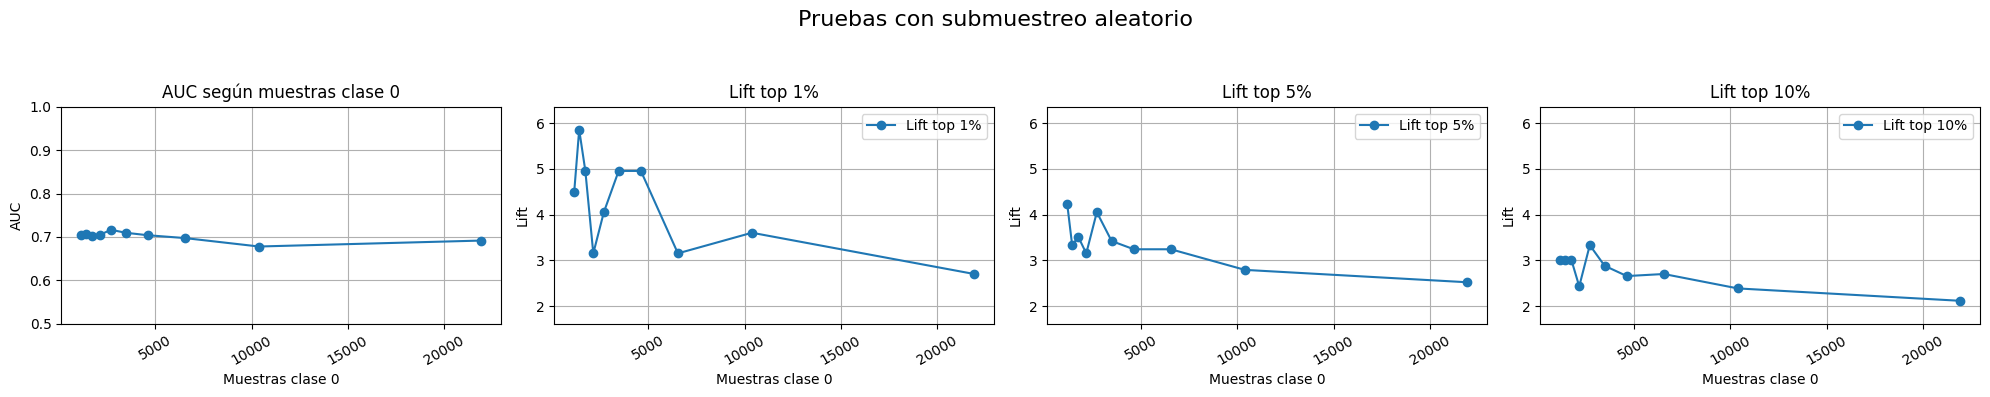

In [ ]:
n_lifts = len(lifts_porcentajes)
fig, axes = plt.subplots(ncols=1 + n_lifts, figsize=(5 * (1 + n_lifts), 4))

# Título general de la figura
fig.suptitle("Pruebas con submuestreo aleatorio", fontsize=16)

# Gráfico del AUC
axes[0].plot(ejemplos0, auc_scores, marker='o')
axes[0].set_title("AUC según muestras clase 0")
axes[0].set_xlabel("Muestras clase 0")
axes[0].set_ylabel("AUC")
axes[0].set_ylim(0.5, 1)
axes[0].set_yticks([round(i * 0.1, 1) for i in range(5, 11)])  # ticks de 0.5 a 1.0 en pasos de 0.1
axes[0].tick_params(axis='x', rotation=30) 
axes[0].grid(True)

# --- Calcular min y max global de Lift ---
all_lift_values = []
for lift_vals in lifts_porcentajes.values():
    all_lift_values.extend(lift_vals)

min_lift_global = min(all_lift_values)
max_lift_global = max(all_lift_values)

# Gráficos de los lifts
for i, (p, lift_vals) in enumerate(lifts_porcentajes.items(), start=1):
    axes[i].plot(ejemplos0, lift_vals, marker='o', label=f"Lift top {p}%")
    axes[i].set_title(f"Lift top {p}%")
    axes[i].set_xlabel("Muestras clase 0")
    axes[i].set_ylabel("Lift")
    axes[i].set_ylim(min_lift_global-0.5, max_lift_global+0.5)
    axes[i].tick_params(axis='x', rotation=30) 
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


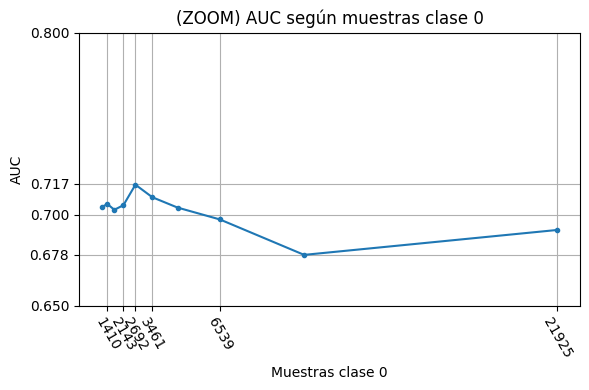

In [8]:
# Encontrar el índice del máximo AUC
i_max_auc = auc_scores.index(max(auc_scores))
x_val_max_auc = ejemplos0[i_max_auc]

# Construir los xticks asegurando que incluya el del máximo AUC
xticks_custom = ejemplos0[::2]
if x_val_max_auc not in xticks_custom:
    xticks_custom.append(x_val_max_auc)
    xticks_custom = sorted(xticks_custom)  # Ordenar por si lo insertaste fuera de orden

# Nueva gráfica solo del AUC con ylim personalizado
plt.figure(figsize=(6, 4))
plt.plot(ejemplos0, auc_scores, marker='o', markersize=3)
plt.title("(ZOOM) AUC según muestras clase 0")
plt.xlabel("Muestras clase 0")
plt.ylabel("AUC")
plt.ylim(0.65, 0.75)
plt.yticks([0.65, 0.7, 0.8, round(max(auc_scores), 3), round(min(auc_scores), 3)])
plt.xticks(xticks_custom, rotation=-60)
plt.grid(True)
plt.tight_layout()
plt.show()


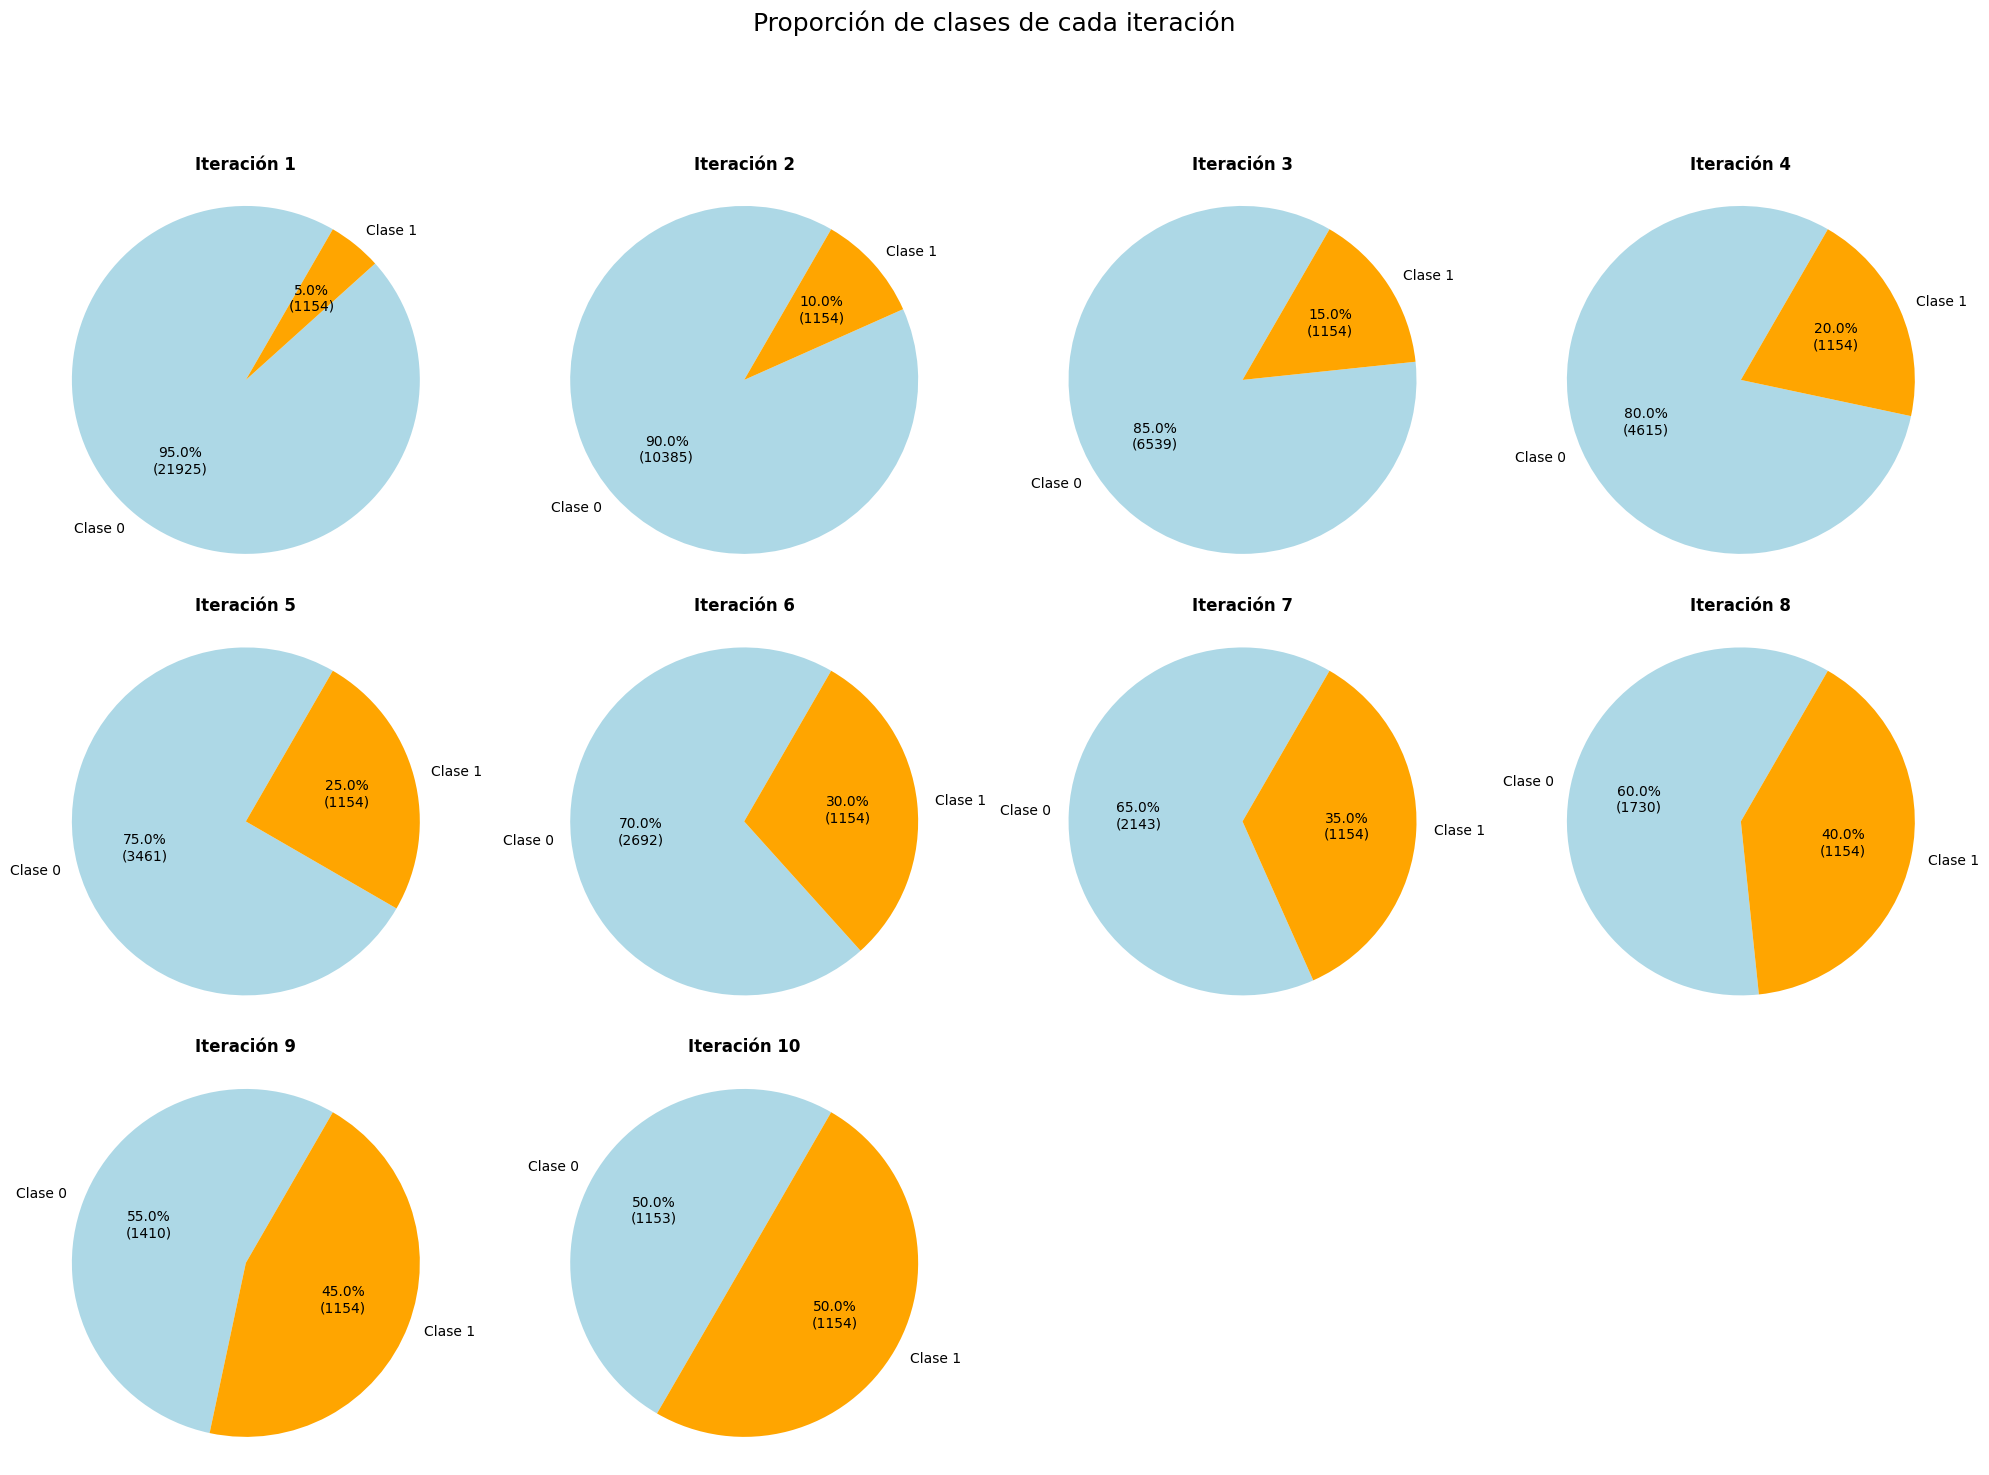

In [9]:
counter = Counter(y_train)

# Número fijo de ejemplos de clase 0
n_clase_1 = counter[1]
# Total de gráficos
total = len(ejemplos0)
ncols = 4
nrows = math.ceil(total / ncols)

# Crear subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

# Asegurarse de que axes es un array plano iterable
axes = axes.flatten()

# Título general
fig.suptitle("Proporción de clases de cada iteración", fontsize=18)

# Función para formato combinado de % y cantidad
def make_autopct(sizes):
    def autopct(pct):
        total = sum(sizes)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return autopct

for i, n_clase_0 in enumerate(ejemplos0):
    sizes = [n_clase_0, n_clase_1]
    labels = ['Clase 0', 'Clase 1']
    colors = ['lightblue', 'orange']
    axes[i].pie(
        sizes, 
        labels=labels, 
        autopct=make_autopct(sizes), 
        colors=colors, 
        startangle=60
    )
    axes[i].axis('equal')
    axes[i].set_title(f'Iteración {i+1}', fontsize=12, fontweight='bold')

# Eliminar subplots sobrantes si los hay
for j in range(len(ejemplos0), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
